# **Network IPS with enhancements for DDoS attack detection**

In this project we are trying to build a network intrusion prevention system to detect different kinds of attacks on the SDN controller specially DDoS attacks. We used both machine and deep learning algorithms to build a better system.

The following are the detailed steps and code explaining the whole system.


# ***1) Importing needed libraries***
We thought it best to collect all used python libraries in one section instead of just leaving them sparsed in the whole project to be imported all at once.

In [ ]:
%matplotlib inline
# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
import pickle

# Visualization 
import matplotlib.pyplot as plt

#import missingno
import seaborn as sn
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,classification_report,confusion_matrix
from sklearn.manifold import TSNE
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn.datasets import load_iris, load_boston
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from collections import defaultdict
!pip install category_encoders
import category_encoders as ce


# Deep learning libraries
import keras
from keras import layers
from keras import Model
from keras.optimizers import RMSprop
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.callbacks import TensorBoard
from keras import backend as K
#from keras.utils import plot_model

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

# To import dataset files from google drive into google colab
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***2) Data preprocessing and visualizing***

In this section we import data files used for training and testing the model. Then, we apply multiple operations on data such as: filling nulls, removing outlayers and encoding (label,hashing).
We also take a closer look at the used data and analyze it using some graphs.

We used The (UNSW_NB15) dataset for training and testing the model. You can find more about it and download it from the following link (https://www.kaggle.com/mrwellsdavid/unsw-nb15)



In [ ]:
# Reading data files 
df1 = pd.read_csv('/content/drive/MyDrive/Dataset/UNSW-NB15_1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Dataset/UNSW-NB15_2.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Dataset/UNSW-NB15_3.csv')
df4 = pd.read_csv('/content/drive/MyDrive/Dataset/UNSW-NB15_4.csv')

# Adding columns names to data
columns=['srcip','sport','dstip','dsport','proto','state','dur','sbytes','dbytes','sttl', 'dttl', 'sloss', 'dloss','service', 'sload','dload','spkts','dpkts','swin','dwin','stcpb','dtcpb','smeansz','dmeansz','trans_depth','res_bdy_len', 'sjit','djit', 'stime','ltime','sintpkt','dintpkt','tcprtt','synack','ackdat','is_sm_ips_ports','ct_state_ttl','ct_flw_http_mthd' ,'is_ftp_login','ct_ftp_cmd','ct_srv_src','ct_srv_dst','ct_dst_ltm','ct_src_ ltm','ct_src_dport_ltm','ct_dst_sport_ltm','ct_dst_src_ltm','attack_cat','label']
df1.columns = columns
df2.columns = columns
df3.columns = columns
df4.columns = columns

# Combining all files in one file called (data).
dfs = [ df1, df2, df3, df4]
data = pd.concat(dfs).reset_index()
data.drop('index',axis=1,inplace=True)

data.head()



,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.891010,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0.0,0.0,0,2,4,2,3,1,1,2,NaN,0
1,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,12,8,1,2,2,1,1,NaN,0
2,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.000000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0.0,0.0,0,6,9,1,1,1,1,1,NaN,0
3,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0.0,0.0,0,7,9,1,1,1,1,1,NaN,0
4,59.166.0.0,32119,149.171.126.9,111,udp,CON,0.078339,568,312,31,29,0,0,-,43503.23438,23896.14258,4,4,0,0,0,0,142,78,0,0,29.682221,34.370340,1421927414,1421927414,21.003,24.315000,0.0,0.0,0.0,0,0,0.0,0.0,0,2,4,2,3,1,1,2,NaN,0


In [ ]:
# Finding missing values in the dataset
data.isnull().sum().sort_values(ascending=False)[0:5]

attack_cat          2218760
is_ftp_login        1429877
ct_flw_http_mthd    1348143
label                     0
sloss                     0
dtype: int64

In [ ]:
# Finding number of attack samples in the dataset
data.query('label == 1')

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
19,175.45.176.3,21223,149.171.126.18,32780,udp,INT,0.000021,728,0,254,0,0,0,-,1.386667e+08,0.000000,2,0,0,0,0,0,364,0,0,0,0.000000,0.000000,1421927415,1421927415,0.021000,0.000000,0.000000,0.000000,0.000000,0,2,0.0,0.0,0,1,1,1,1,1,1,1,Exploits,1
20,175.45.176.2,23357,149.171.126.16,80,tcp,FIN,0.240139,918,25552,62,252,2,10,http,2.805042e+04,815794.187500,12,24,255,255,1708297952,1939490744,77,1065,1,12026,1170.481668,1144.383360,1421927416,1421927416,21.830818,9.570304,0.051475,0.006528,0.044947,0,1,1.0,0.0,0,3,2,2,1,1,1,1,Exploits,1
21,175.45.176.0,13284,149.171.126.16,80,tcp,FIN,2.390390,1362,268,254,252,6,1,http,4.233619e+03,749.668518,14,6,255,255,3897219059,2466816006,97,45,1,0,18786.711400,941.724938,1421927414,1421927416,183.579303,474.259406,0.066088,0.017959,0.048129,0,1,1.0,0.0,0,5,2,2,1,1,1,1,Reconnaissance,1
38,175.45.176.2,13792,149.171.126.16,5555,tcp,FIN,0.175190,8168,268,254,252,4,1,-,3.463668e+05,10228.894530,14,6,255,255,2505143795,3592239707,583,45,0,0,774.788316,47.765387,1421927417,1421927417,11.837692,33.287000,0.054878,0.008744,0.046134,0,1,0.0,0.0,0,1,1,1,1,1,1,1,Exploits,1
39,175.45.176.2,26939,149.171.126.10,80,tcp,FIN,0.190600,844,268,254,252,2,1,http,3.189927e+04,9401.888672,10,6,255,255,3006332195,1452987536,84,45,1,0,996.632407,59.532129,1421927418,1421927418,18.573778,36.845602,0.050675,0.006354,0.044321,0,1,1.0,0.0,0,3,1,1,1,1,1,1,Exploits,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540023,175.45.176.0,47439,149.171.126.10,53,udp,INT,0.000001,114,0,254,0,0,0,dns,4.560000e+08,0.000000,2,0,0,0,0,0,57,0,0,0,0.000000,0.000000,1424262068,1424262068,0.001000,0.000000,0.000000,0.000000,0.000000,0,2,NaN,NaN,,15,15,15,15,15,15,15,Generic,1
2540024,175.45.176.0,17293,149.171.126.17,110,tcp,CON,0.942984,574,676,62,252,5,6,-,4.470914e+03,5259.898438,12,12,255,255,3026824982,3748412468,48,56,0,0,3903.523582,95.650531,1424262068,1424262069,79.714089,80.827180,0.139446,0.053884,0.085562,0,3,NaN,NaN,,2,1,2,4,2,2,2,Exploits,1
2540025,175.45.176.0,33654,149.171.126.12,80,tcp,CON,2.579405,269883,1300,62,252,103,1,-,8.330169e+05,3898.573486,208,30,255,255,183420721,3548597985,1298,43,1,0,1701.614470,138.857703,1424262066,1424262069,12.239136,86.655617,0.159923,0.066388,0.093535,0,3,2.0,NaN,,2,1,2,4,2,2,2,DoS,1
2540026,175.45.176.0,33654,149.171.126.12,80,tcp,CON,2.579405,269883,1300,62,252,103,1,http,8.330169e+05,3898.573486,208,30,255,255,183420721,3548597985,1298,43,1,0,1701.614470,138.857703,1424262066,1424262069,12.239136,86.655617,0.159923,0.066388,0.093535,0,3,2.0,NaN,,1,1,2,4,2,2,2,DoS,1


In [ ]:
# Attack types in the datasets
data.attack_cat.unique()

array([nan, 'Exploits', 'Reconnaissance', 'DoS', 'Generic', 'Shellcode',
       ' Fuzzers', 'Worms', 'Backdoors', 'Analysis', ' Reconnaissance ',
       'Backdoor', ' Fuzzers ', ' Shellcode '], dtype=object)

In [ ]:
# Looking at the different values in the service column in the dataset
data.service.value_counts()

-           1246395
dns          781667
http         206273
ftp-data     125783
smtp          81644
ftp           49090
ssh           47160
pop3           1533
dhcp            172
ssl             142
snmp            113
radius           40
irc              31
Name: service, dtype: int64

In [ ]:
# replacing '-' values in service with 'notservice'
data.service.replace('-','notservice',inplace=True)

In [ ]:
# Exploring protocols values in the dataset
data.proto.unique()

array(['udp', 'arp', 'tcp', 'ospf', 'icmp', 'igmp', 'sctp', 'udt', 'sep',
       'sun-nd', 'swipe', 'mobile', 'pim', 'rtp', 'ipnip', 'ip', 'ggp',
       'st2', 'egp', 'cbt', 'emcon', 'nvp', 'igp', 'xnet', 'argus',
       'bbn-rcc', 'chaos', 'pup', 'hmp', 'mux', 'dcn', 'prm', 'trunk-1',
       'xns-idp', 'trunk-2', 'leaf-1', 'leaf-2', 'irtp', 'rdp', 'iso-tp4',
       'netblt', 'mfe-nsp', 'merit-inp', '3pc', 'xtp', 'idpr', 'tp++',
       'ddp', 'idpr-cmtp', 'ipv6', 'il', 'idrp', 'ipv6-frag', 'sdrp',
       'ipv6-route', 'gre', 'rsvp', 'mhrp', 'bna', 'esp', 'i-nlsp',
       'narp', 'ipv6-no', 'tlsp', 'skip', 'ipv6-opts', 'any', 'cftp',
       'sat-expak', 'kryptolan', 'rvd', 'ippc', 'sat-mon', 'ipcv', 'visa',
       'cpnx', 'cphb', 'wsn', 'pvp', 'br-sat-mon', 'wb-mon', 'wb-expak',
       'iso-ip', 'secure-vmtp', 'vmtp', 'vines', 'ttp', 'nsfnet-igp',
       'dgp', 'tcf', 'eigrp', 'sprite-rpc', 'larp', 'mtp', 'ax.25',
       'ipip', 'micp', 'aes-sp3-d', 'encap', 'etherip', 'pri-enc', 'gmtp'

8786.637695 0.0


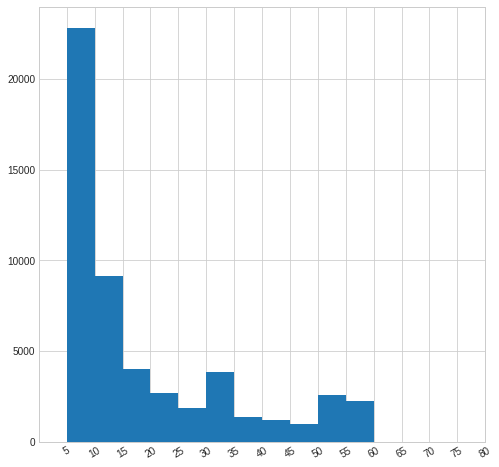

In [ ]:
# Max and min values in duration feature
print(data['dur'].max(),data['dur'].min())
binss = np.arange(5,9000,5)
plt.figure(figsize=[8,8])
plt.hist(data['dur'],bins=binss);
plt.xticks(binss,binss,rotation=30);
plt.xlim(0,80);

Almost all traffic durations in the dataset lie between 0~60 secs. There were about 6 samples that had 8786 Secs , so we considered them as outliers and removed them.

In [ ]:
# seeing how many values in 'dur' larger thatn 60 Secs
print("How many values in 'dur' is larger than 60 secs ?",data[data.dur > 60].shape[0])

How many values in 'dur' is larger than 60 secs ? 6


In [ ]:
# dropping outliers in dur 
data.drop(data[data.dur > 60].index,inplace=True)

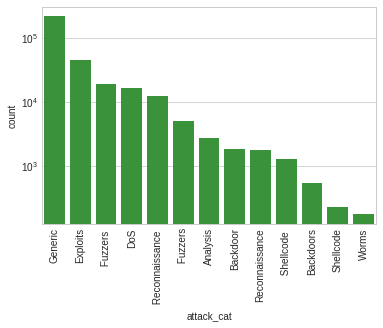

In [ ]:
order=data.attack_cat.value_counts().index
sb.countplot(data=data,x='attack_cat',order=order,color=sb.color_palette()[2]);
plt.yscale('log');
plt.xticks(rotation = 90);

This graph shows the number of occurrences of each attack category in the UNSW-NB15 dataset; DoS attack is in the 4th location with 16,353 samples.

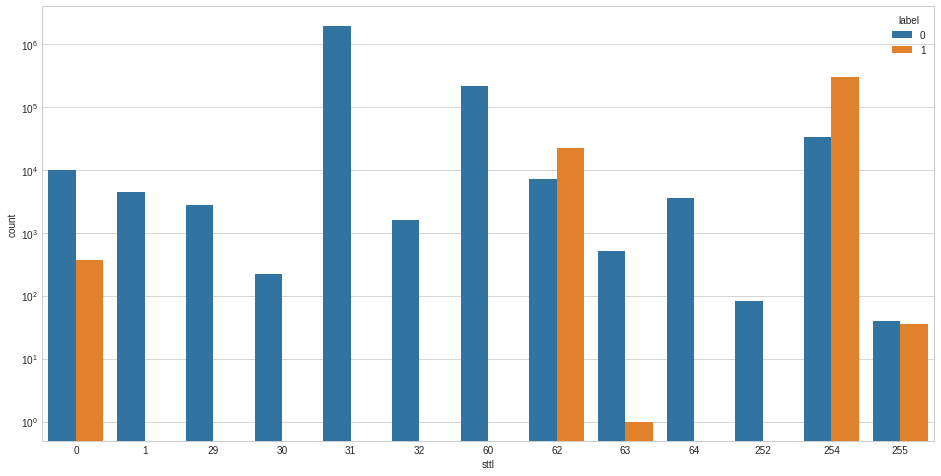

In [ ]:
# sttl values
plt.figure(figsize=[16,8])
sb.countplot(data = data, x = 'sttl', hue =  'label')
plt.yscale('log')

When we started creating models and seeing the significance of features in predictions, we found something weird. ANY features had a relation with “TTL” considered Very significant to the models. This graph explains why that, there are some values that consider just attack and others consider just normal. We excluded these features to avoid overfitting.

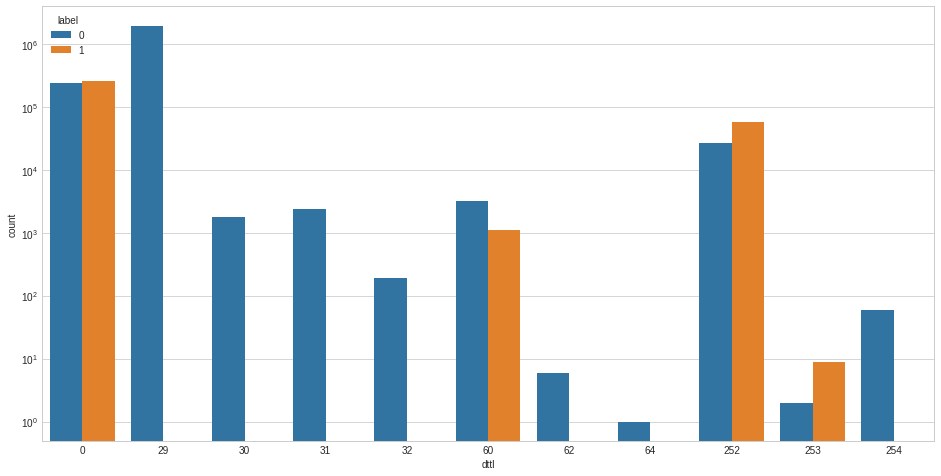

In [ ]:
# dttl values
plt.figure(figsize=[16,8])
sb.countplot(data = data, x = 'dttl', hue =  'label')
plt.yscale('log')

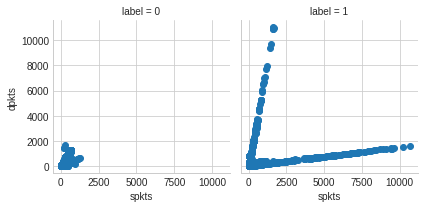

<Figure size 576x576 with 0 Axes>

In [ ]:
g =sb.FacetGrid(data=data,col='label' )
plt.figure(figsize=[8,8])
g.map(plt.scatter,'spkts','dpkts')


This graph clarifies that normal traffic tends to have a small number of source and destination packets, In contrast, the attack traffic tends more to have either a high number of source or destination packets.


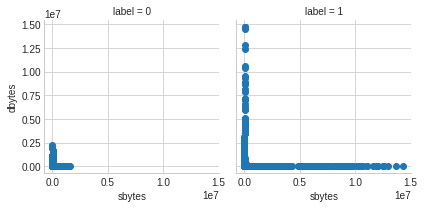

<Figure size 576x576 with 0 Axes>

In [ ]:
g =sb.FacetGrid(data=data,col='label' )
plt.figure(figsize=[8,8])
g.map(plt.scatter,'sbytes','dbytes')

The same idea of the previous graph goes for this one. So, the normal traffic will have a small
number of Bytes, whereas the attack one will have a large number of bytes in either source or destination traffic.


In [ ]:
# Making sure that the data has no nulls anymore
data.isnull().sum()

proto      0
dur        0
sbytes     0
dbytes     0
sloss      0
dloss      0
service    0
sload      0
dload      0
spkts      0
dpkts      0
swin       0
dwin       0
stcpb      0
dtcpb      0
smeansz    0
dmeansz    0
sjit       0
djit       0
stime      0
ltime      0
label      0
dtype: int64

In [ ]:
# Saving the cleaned data in one file to be easily accessed
data.to_csv('/content/drive/MyDrive/Data/cleaned_data.csv',index = False)

In [ ]:
# Reading the cleaned data file for easier use in the future
data = pd.read_csv('/content/drive/MyDrive/Data/cleaned_data.csv')

**Used features in the model**

It is imperative to say here that this project is part of a larger project (actually our graduation project) and the idea of this model is to deploy it on an SDN network controller. We are not interested in the controller part here but we had to only use the features that our SDN controller team managed to capture at the time. With that being said, there is a section at the end of this project called (Extras) , there you can find a feature selection algorithms that we managed to create and test, we just didn't use in the main project for the previuos reasons but we wanted to share it with you.

In [ ]:
# Dropping unused features
# We only used about the first 21 feature
# We dropped port numbers and IPs as they will cause overfitting, also dropped some columns that have huge NaNs
# List of Features that Implemenataion subteam succeeded to extract + label

imp_features= ['proto','dur','sbytes','dbytes','sloss','dloss','service','sload','dload','spkts','dpkts','swin','dwin','stcpb','dtcpb','smeansz','dmeansz','sjit','djit','stime','ltime','label']
data = data.loc[:,imp_features]

In [ ]:
# Applying label encoder for the dataset that will be used in the supervised model
Supervised_data = data.copy()
col =[]
for column in Supervised_data.columns :
    if Supervised_data[column].dtype == object :
        col.append(column)  
for column in col :
    le = LabelEncoder()
    print(column)
    le.fit(Supervised_data[column])
    
    Supervised_data[column]=le.transform(Supervised_data[column])
   

proto
service


# ***3) The Models*** 
Here we have two models: Supervised machine learning model and Unsupervised deep learning model 

The unsupervised model is used at the beginning before the supervised one to check if the flow (data) is suspicious or not. If the flow looks normal, it is allowed to pass peacefully without further checks ant it doesn't inovke any other investigation (the supervised one).

If the flow looks suspicious, the supervised model is invoked and 
used to investigate this flow to see if it is really an attack or not to to inform the controller to take the needed action

***A) Unsupervised deep learning model***

Here we built an Unsupervised deep learning model to perform an initial investigation of the data.

For building this model, we used the already prepared train and test dataset files.

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/Dataset/UNSW_NB15_testing-set.csv")
train = pd.read_csv("/content/drive/MyDrive/Dataset/UNSW_NB15_testing-set.csv")
UNs_imp_features=['proto','dur','sbytes','dbytes','sloss','dloss','service','sload','dload','spkts','dpkts','swin','dwin','stcpb','dtcpb','sjit','djit','attack_cat','label']
train=train.loc[:,UNs_imp_features]
test=test.loc[:,UNs_imp_features]
train.service.replace('-','notservice',inplace=True)
test.service.replace('-','notservice',inplace=True)
hash_encoder = ce.HashingEncoder(cols= ["proto","service"],n_components = 13)
train = hash_encoder.fit_transform(train,train.label)
test = hash_encoder.transform(test)

In [ ]:
def mse(pred,true):
    result = []
    for sample1,sample2 in zip(pred,true):
        error = sum((sample1.astype("float") - sample2.astype("float")) ** 2)
        error /= float(len(sample2))
        result.append(error)
    return np.array(result)

def get_losses(model, x):
    reconstruct_err = []
    pred = model.predict(x)
    err = mse(x, pred)
    return err
def confidence_intervals(data, confidence=0.97):
    n = len(data)
    # mean & standard deviation
    mean, std_dev = np.mean(data), data.std()
    z_critical = stats.norm.ppf(q = confidence)
    margin_of_error = z_critical * (std_dev/np.sqrt(n))
    return [mean-margin_of_error, mean+margin_of_error]
def predictAnomaly(model,x,threshold):
    pred = model.predict(x)
    MSE = mse(pred,x)
    res = np.where(MSE <= threshold,0,1) #anomaly : 1, normal : 0
    return res
def performance(true,pred,title="confusion matrix"):
    acc = accuracy_score(pred,true)
    print("Accurary : ",acc)
    f1 = f1_score(true,pred)
    print("F1 Score : ",f1)

    print("Classification report")
    print(classification_report(pred,true))
    df_cm = pd.DataFrame(confusion_matrix(true,pred), index = ["Anomal","Normal"],
                      columns = ["Anomal","Normal"])
    plt.figure(figsize = (10,7))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(title,fontsize=20)
    fig = sn.heatmap(df_cm,fmt='g',annot=True,annot_kws={"size": 20})
    plt.show()
def get_TSNE(dim_reducer,x,labels):

    test_reduced = dim_reducer.predict(x)
    test_embedded = TSNE(n_components=2).fit_transform(test_reduced)

    # with open('test_tsne.pickle', 'wb') as f:
    #             pickle.dump(test_embedded, f)

    plt.scatter(test_embedded[:,0], test_embedded[:,1], c = labels)
    plt.show()

In [ ]:
DoS=train.query('attack_cat=="DoS"').index
Normal=train.query('attack_cat=="Normal"').index
train.drop(['attack_cat','label'],axis=1, inplace =True)

In [ ]:
#Performing standard scaler
Scaler = StandardScaler()
dd = Scaler.fit_transform(train.values)
normal_traffic =dd[Normal]
dos_traffic = dd[DoS]

In [ ]:
#Building the model
def fit_model(X,lr=0.0005,ep=50, bs=100):
    input_dim = X.shape[1]
    latent_space_size = 10
    K.clear_session()
    input_ = Input(shape = (input_dim, ))

    layer_1 = Dense(50, activation='tanh')(input_)
    layer_2 = Dense(25, activation='tanh')(layer_1)
    layer_3 = Dense(15, activation='tanh')(layer_2)

    encoding = Dense(latent_space_size,activation=None)(layer_3)

    layer_5 = Dense(15, activation='tanh')(encoding)
    layer_6 = Dense(25, activation='tanh')(layer_5)
    layer_7 = Dense(50, activation='tanh')(layer_6)

    decoded = Dense(input_dim,activation=None)(layer_7)

    autoencoder = Model(inputs=input_ , outputs=decoded)
    autoencoder.compile(metrics=['accuracy'],loss='mean_squared_error',optimizer="adam")
    autoencoder.fit(X, X,epochs=ep,validation_split=0.2,batch_size=bs,shuffle=True,verbose=1)
    return autoencoder


In [ ]:
#Training the model
autoencoder=fit_model(normal_traffic)

Epoch 1/50
448/448 [==============================] - 15s 4ms/step - loss: 0.3726 - accuracy: 0.5670 - val_loss: 0.4656 - val_accuracy: 0.6455
Epoch 2/50
448/448 [==============================] - 1s 3ms/step - loss: 0.0823 - accuracy: 0.8338 - val_loss: 0.2650 - val_accuracy: 0.8191
Epoch 3/50
448/448 [==============================] - 1s 3ms/step - loss: 0.0450 - accuracy: 0.9114 - val_loss: 0.2357 - val_accuracy: 0.8787
Epoch 4/50
448/448 [==============================] - 1s 3ms/step - loss: 0.0383 - accuracy: 0.9128 - val_loss: 0.2194 - val_accuracy: 0.8416
Epoch 5/50
448/448 [==============================] - 1s 2ms/step - loss: 0.0332 - accuracy: 0.9175 - val_loss: 0.1832 - val_accuracy: 0.8632
Epoch 6/50
448/448 [==============================] - 1s 3ms/step - loss: 0.0252 - accuracy: 0.9148 - val_loss: 0.1487 - val_accuracy: 0.7355
Epoch 7/50
448/448 [==============================] - 1s 3ms/step - loss: 0.0132 - accuracy: 0.9191 - val_loss: 0.1218 - val_accuracy: 0.8093
Epoch

Accurary :  0.9615357142857143
F1 Score :  0.0
Classification report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     53846
           1       0.00      0.00      0.00      2154

    accuracy                           0.96     56000
   macro avg       0.48      0.50      0.49     56000
weighted avg       0.92      0.96      0.94     56000



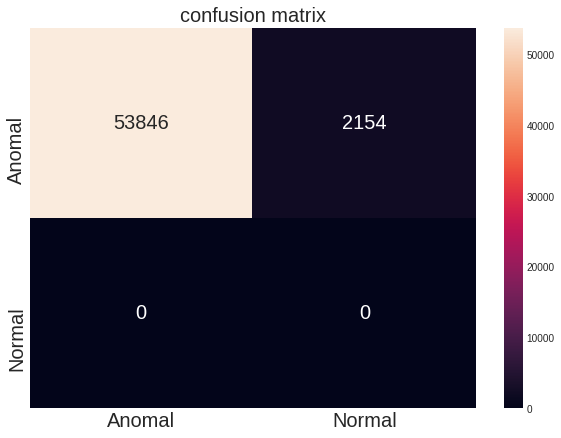

In [ ]:
#Normal detection performance
losses = get_losses(autoencoder, normal_traffic)
thresholds = confidence_intervals(losses,0.95)
threshold = thresholds[1]
train_pred = predictAnomaly(autoencoder,normal_traffic,threshold)
test_pred = predictAnomaly(autoencoder,dos_traffic,threshold)
Normal_Label = [0] * len(train_pred)
Dos_Label = [1] * len(test_pred)
performance(Normal_Label,train_pred )


Accurary :  0.8056914546640574
F1 Score :  0.892391058929781
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2383
           1       0.81      1.00      0.89      9881

    accuracy                           0.81     12264
   macro avg       0.40      0.50      0.45     12264
weighted avg       0.65      0.81      0.72     12264



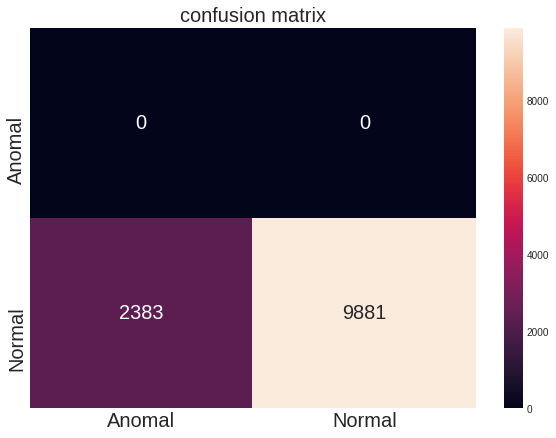

In [ ]:
#Anomaly detection performance
performance(Dos_Label,test_pred )

***B) Supervised machine learning model***

In this part we used a supervised machine learning model to check the suspicious data (flow) that was passed by the unspervised DL model for further investigation to inform the controller with the proper action.

**Choosing best algorithm for the model**

In this part we try to find the best algorithm to be used so we tried many different algorithms such as: Gradient boost, Random forest, decision tree, a deep learning model, and some others. we then compared their efficiency and run time too because we need the model to be able to detect attacks fast and accurately. You can take a look at the differenet tries below along with their results.


In [ ]:
# Machine learning algorithm selection
X_train, X_test, y_train, y_test = train_test_split(Supervised_data.iloc[:,:-1],Supervised_data.iloc[:,-1], test_size=0.2, random_state=42,shuffle=True)

model_RF = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0 )
model_DT = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
model_LR = LogisticRegression(random_state = 0)
model_NB = GaussianNB()
model_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=5, random_state=0)


#Normalization
#from sklearn.preprocessing import MinMaxScaler
for ee in X_train.columns:
# fit on training data column
  scale = MinMaxScaler().fit(X_train[[ee]])  
# transform the training data column
  X_train[ee] = scale.transform(X_train[[ee]])      
# transform the testing data column
  X_test[ee] = scale.transform(X_test[[ee]])

model_list = [model_RF , model_DT , model_LR , model_NB ,model_GB ]
model_names = ['Random Forest', 'Decision Tree' ,'Logistic Regression','Naive Bayes','Gradient Boost']


for model in model_list:
  model.fit(X_train,y_train)
  print(model_names[model_list.index(model)])
  print("Train Accuracy : ",model.score(X_train, y_train) *100,"%")
  print("Test Accuracy : ",model.score(X_test, y_test) *100,"%")

  start = time.time()
  y_pred = model.predict(X_test) 
  finish = time.time()
  print ('Testing time = ',finish - start , 'seconds')
  cm = confusion_matrix(y_test, y_pred)
  print('Confusion Matrix')
  print(cm)
  print('----------------------------------------------------------------------')

Random Forest
Train Accuracy :  99.9687013111001 %
Test Accuracy :  99.56398410264386 %
Testing time =  0.5556495189666748 seconds
Confusion Matrix
[[442763    906]
 [  1309  63031]]
----------------------------------------------------------------------
Decision Tree
Train Accuracy :  99.99576778735 %
Test Accuracy :  99.57894446751928 %
Testing time =  0.05222773551940918 seconds
Confusion Matrix
[[442589   1080]
 [  1059  63281]]
----------------------------------------------------------------------
Logistic Regression
Train Accuracy :  87.5467634891936 %
Test Accuracy :  87.53270119230172 %
Testing time =  0.015947341918945312 seconds
Confusion Matrix
[[442430   1239]
 [ 62096   2244]]
----------------------------------------------------------------------
Naive Bayes
Train Accuracy :  86.99318023222052 %
Test Accuracy :  87.00377355519292 %
Testing time =  0.11585617065429688 seconds
Confusion Matrix
[[390868  52801]
 [ 13221  51119]]
------------------------------------------------

'model = DecisionTreeClassifier(criterion = \'entropy\', random_state = 0)\n\n#Normalization\n\nfor ee in X_train.columns:\n# fit on training data column\n  scale = MinMaxScaler().fit(X_train[[ee]])  \n# transform the training data column\n  X_train[ee] = scale.transform(X_train[[ee]])      \n# transform the testing data column\n  X_test[ee] = scale.transform(X_test[[ee]])\n\n\nmodel.fit(X_train,y_train)\n\nprint("Train Accuracy : ",model.score(X_train, y_train) *100,"%")\nprint("Test Accuracy : ",model.score(X_test, y_test) *100,"%")\n\n# Measuring test time\nstart = time.time()\ny_pred = model.predict(X_test) \nfinish = time.time()\nprint (\'Test time >>> \', finish - start , \'seconds\')\ncm = confusion_matrix(y_test, y_pred)\nprint(cm)'

**Choosing best activation function for the deep learning model**

Choosing the best activation function in your model is an important step. There are many activation functions that can be used in deep learning such as: relu,tanh, and sigmoid. That's why we used a (5-fold cross validation) to help us determine which activation function is best.
The model itsef is rather simple. It consists of 10-layers and each layer has 10 neurons. We also used (Adam) optimization algorithm and regularization.

In [ ]:
#Deep learning model with 5-fold cross validation
dfs = []
kf = KFold(n_splits = 5, shuffle=True, random_state=123)
i = 1

accu_mat = []
time_mat = []

features = []
for rrr in Supervised_data.columns[:-1]:
    features.append(rrr)

activ_list = ['relu','tanh','sigmoid']

for kkk in activ_list :
  # initialize the model
  tf.keras.backend.clear_session()
  model = tf.keras.models.Sequential()
  model.add(tf.keras.Input(shape=(None,21)))
  model.add(tf.keras.layers.Dense(10, activation= kkk ,activity_regularizer=regularizers.l1(1e-4)))
  model.add(tf.keras.layers.Dense(10, activation= kkk ,activity_regularizer=regularizers.l1(1e-4)))
  model.add(tf.keras.layers.Dense(10, activation= kkk ,activity_regularizer=regularizers.l1(1e-4)))
  model.add(tf.keras.layers.Dense(10, activation= kkk ,activity_regularizer=regularizers.l1(1e-4)))
  model.add(tf.keras.layers.Dense(10, activation= kkk ,activity_regularizer=regularizers.l1(1e-4)))
  model.add(tf.keras.layers.Dense(10, activation= kkk ,activity_regularizer=regularizers.l1(1e-4)))
  model.add(tf.keras.layers.Dense(10, activation= kkk ,activity_regularizer=regularizers.l1(1e-4)))
  model.add(tf.keras.layers.Dense(10, activation= kkk ,activity_regularizer=regularizers.l1(1e-4)))
  model.add(tf.keras.layers.Dense(10, activation= kkk ,activity_regularizer=regularizers.l1(1e-4)))

  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  
  
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='mean_absolute_error',metrics=["accuracy"])
  accu_mat.append(kkk)
  time_mat.append(kkk)

  train_index = 0
  test_index = 0
  print("""
  #
  #
  """)
  print('----------------------------------------------------------------------')
  print('The activation function used is:',kkk,'function')

  for train_index, test_index in kf.split(Supervised_data):
    X_train = Supervised_data.iloc[train_index].loc[:, features]
    X_test = Supervised_data.iloc[test_index].loc[:, features]
    y_train = Supervised_data.iloc[train_index].loc[:,'label']
    y_test = Supervised_data.loc[test_index].loc[:,'label']

    #Normalization
    #from sklearn.preprocessing import MinMaxScaler
    for ee in X_train.columns:
        
        # fit on training data column
        scale = MinMaxScaler().fit(X_train[[ee]])
        
        # transform the training data column
        X_train[ee] = scale.transform(X_train[[ee]])
        
        # transform the testing data column
        X_test[ee] = scale.transform(X_test[[ee]])
     

    
    model.fit(X_train,y_train , epochs = 1 , batch_size= 1024  ) #Training the model
    print('Evaluating the model')
    model.evaluate(X_test, y_test)
    start = time.time()
    y_pred = model.predict(X_test) 
    finish = time.time()
    print ('Testing time = ',finish - start , 'seconds')
    acc_arr = []

    for j in y_pred:
        if j > 0.5:
            acc_arr.append(1)
        else:
            acc_arr.append(0)
                
    cm = 0
    cm = confusion_matrix(y_test, acc_arr)
    print('Confusion matrix')
    print(cm)
    gg = 0
    gg = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,1]+(cm[0,1]+cm[1,0])) *100
    accu_mat.append(gg)
    time_mat.append(finish - start)
    

    # how many occurances appear in the train set
    s_train = data.iloc[train_index].loc[:,'label'].value_counts()
    s_train.name = f"train {i}"
    s_test = data.iloc[test_index].loc[:,'label'].value_counts()
    s_test.name = f"test {i}"
    df = pd.concat([s_train, s_test], axis=1, sort=False)
    df["|"] = "|"
    dfs.append(df)
    
    i += 1
    
print("Accuracy matrix")
print(accu_mat)
print('---------------------------------------------------------------------------------------------------------------------------------------------')
print('Time matrix')
print(time_mat)


  #
  #
  
----------------------------------------------------------------------
The activation function used is: relu function
1985/1985 [==============================] - 8s 3ms/step - loss: 0.1172 - accuracy: 0.9058
Evaluating the model
15876/15876 [==============================] - 16s 1ms/step - loss: 0.0686 - accuracy: 0.9662
Testing time =  9.220144271850586 seconds
Confusion matrix
[[441724   1845]
 [ 15340  49100]]
1985/1985 [==============================] - 7s 3ms/step - loss: 0.0538 - accuracy: 0.9672
Evaluating the model
15876/15876 [==============================] - 16s 1ms/step - loss: 0.0439 - accuracy: 0.9683
Testing time =  10.317735433578491 seconds
Confusion matrix
[[442223   1224]
 [ 14864  49698]]
1985/1985 [==============================] - 7s 3ms/step - loss: 0.0361 - accuracy: 0.9673
Evaluating the model
15876/15876 [==============================] - 16s 1ms/step - loss: 0.0325 - accuracy: 0.9691
Testing time =  10.320029497146606 seconds
Confusion matrix
[[4

# ***Results & Conclusion***



For training the model we used the UNSW-NB15 data set, we developed a two-step model for attack detection; First step is auto encoder to detect anomalies in the flow of new traffic and the a second step is a supervised decision tree classifier to further investigate the anomalies detected by the first step and decide whether the traffic is normal or attack.
8.1 Model Performance
The performance of the model was as following:

●	Auto encoder performance

    Normal traffic detection Accuracy	96%

    DDoS traffic detection Accuracy	78%

●	Decision tree performance

    Training Accuracy	99.95%

    Test Accuracy	99.57%

    Test time	0.0522 ms


# ***Feature Selection***(extra)

In this section we wanted to share with you two of the feature selection methods that we worked on. Unfortunately, as i stated before we just couldn't use them in our main project because we had to use certain features that the SDN controller team managed to collect at the time.


In [ ]:
# Feature selection methods
# First Method of Feature Selection implemented in sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif


fs = SelectKBest(score_func=f_classif, k=20)#'k' value indicate the number of feature you want after selection
fs.fit(abs(train.iloc[:,:-1]), train.loc[:,'label']) # giving Features and labels to see which feature effect labeling
selected_features1 = list(train.columns[fs.get_support(indices=True)]) # list of chose Features

#-------------------------------------------------------------------------------
# Second Method based on P-value
# the method  simply takes the mean of a numeric feature when the label is 0, and the mean when the label is 1 
# then it subtracte the two means, if the output is close to 0, this means that the feature is NOT significant 
# to predicting our label, in contrast, if the value is high this will make the feature crucial to us 

def ztest(feature):
    
    mean = normal[feature].mean()
    std = fraud[feature].std()
    zScore = (fraud[feature].mean() - mean) / (std/np.sqrt(sample_size))
    
    return zScore

columns= train.drop(['label'], axis=1).columns
normal=  train[train.label==0]
fraud=   train[train.label==1]
sample_size=len(fraud)
selected_features2=[] # list of chose Features from second method
critical_value=20

for i in columns:
    
    z_vavlue=ztest(i)
    
    if( abs(z_vavlue) >= critical_value):    
        #print(i," is statistically significant") #Reject Null hypothesis. i.e. H0
        selected_features2.append(i)

